<a href="https://colab.research.google.com/github/gokulsn42/LIGOcodemodulation/blob/main/Circular_convolution_of_bimetric_suppression_of_LIGO_waveform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following line installs PyCBC

In [1]:
pip install -q 'PyCBC==1.18.0' 'lalsuite==6.82'

     |████████████████████████████████| 6.3 MB 13.0 MB/s 
     |████████████████████████████████| 27.3 MB 71 kB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
     |████████████████████████████████| 1.6 MB 45.7 MB/s 
     |████████████████████████████████| 75 kB 5.3 MB/s 
     |████████████████████████████████| 1.0 MB 42.4 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 3.5 MB 41.3 MB/s 


The following code takes a gravitational wave waveform simulated using a selected model in General Relativity and modifies it for a frequency dependent suppression as would be observed by the interference of a massive and massless mode in bimetric gravity. We attempt to reproduce figures from [this paper](https://arxiv.org/pdf/1703.07785.pdf)

size= 4096
4096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


square error =  3.6530240476265695e-40


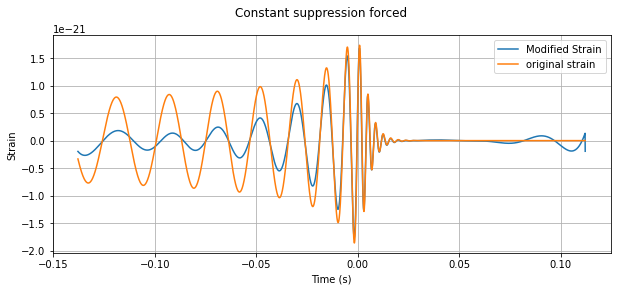

In [2]:
%matplotlib inline
from pycbc.waveform import get_td_waveform
import pylab
import numpy as np
import scipy as sp
import math
pi = np.pi
m1 = 35.6 # solar mass units
m2 = 30.6 # solar mass units
d = 420 # Megaparsec units
f_low=35 # Hertz
def s(omega,theta,mfp,z,h0):#The supression in frequency space
  lz = np.log(1+z)
  s2 = ((math.cos(theta))**4)*(1 + (math.tan(theta))**4 + 2*((math.tan(theta))**2)*math.cos((1.5*10**15)*2*pi*mfp*mfp*lz/(2*h0*(omega))))
  a = np.sqrt(s2)
  return a
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
               mass1 = m1,
               mass2 = m2,
               distance = d,
               delta_t = 1.0/16384,
               f_lower = f_low)
theta = pi/4
h0 = 1.49*10**(-33)
z = 0.09
mfp = 5*10**(-23) #seems to work for something like 5*10^-23
#let us look at only cross polarisation for now
size = 4096
hcshort = np.zeros(size)
shorttimes  = np.zeros(size)
for i in range(0,size):
  hcshort[i] = hc[i]
  shorttimes[i] = hc.sample_times[i]
sf = np.zeros(size)
fmin = 0
fmax = 8192 #NYQUIST FREQUENCY
omgstart = 2*pi*0.01
omgend = 2*pi*8192
halfsize = int(size/2)
omg1 = np.linspace(omgstart,omgend,num= halfsize)#NEEDS TO BE CHANGED DEPENDING ON WHICH OBSERVATION WE ARE LOOKING AT
omg2 = np.linspace(-1*omgend,omgstart,num = halfsize)
omg = np.zeros(size)
for i in range(0,halfsize):
  omg[i] = omg1[i]
  omg[halfsize+i] = omg2[i]
print("size=",size)
# WE NOW NEED TO REORDER THE INPUT THE RIGHT WAY FOR IFFT
for i in range(0,size):
  omgi = omg[i]
  sf[i] = s(omgi,theta,mfp,z,h0)
st = np.fft.ifft(sf)
freqstrain = np.fft.fft(hcshort,n=size)
print(len(st))
#do circular convolution of st and hc
cmatrix = np.zeros((size,size))
for i in range(0,size):
  for j in range(0,size):
    cmatrix[j][i] = st[(i+j)%size]
hcarr = np.zeros(size)
for i in range(0,size):
  hcarr[i] = hcshort[i]
modwave = np.matmul(cmatrix,hcarr)
marr = np.zeros(size)
for i in range(0,size):
  marr[i] = modwave[i]
for i in range(0,size):
  modwave[i] = marr[size-1-i]
#modwave.reverse()
#modwave = np.zeros(size)
#for i in range(0,size-1):
#  modwave[i] = modwaveunscaled[2*i]
#modwave[size-1] = 0
#tempxaxis = np.linspace(1,2*size-1,num=2*size-1)
pylab.figure(figsize=pylab.figaspect(0.4))
#pylab.plot(hp.sample_times,st,label="modifications freq")
#pylab.plot(hp.sample_times,st,label="modifications")
#pylab.plot(tempxaxis,modwaveunscaled,label='unscaled modified strain')
#fig, (ax1, ax2) = pylab.subplots(2)
pylab.plot(shorttimes,modwave,label='Modified Strain')
pylab.plot(shorttimes, hcshort, label='original strain')
#pylab.plot(omg,sf,label='suppression factor')
error = 0
for i in range(0,3000):
  if(hcshort[i] != 0):
    error = error + ((modwave[i]-hcshort[i])**2)
sqrterror = np.sqrt(error)
print('square error = ',error)
#pylab.plot(hc.sample_times,sf,label='supression as function of frequency')
#pylab.plot(hp.sample_times, st,label = 'strain in time basis')
#pylab.plot(hp.sample_times,freqstrain,label='ft of strain')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
title = "Constant suppression forced "
#title = title + str(mfp)
pylab.suptitle(title)
#pylab.xlim(-.05, .05)
pylab.legend()
pylab.grid()
pylab.show()

